<a href="https://colab.research.google.com/github/antoniovfonseca/agentic-ai-global-lulc/blob/main/notebooks/overview-glance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/antoniovfonseca/agentic-ai-global-lulc/blob/main/notebooks/overview-glance.ipynb)

## **1. Import of geospatial processing and visualization modules.**
---



In [1]:
# Enter your Google Cloud Project ID
project_id = "ee-antoniovicgf"

In [2]:
import os
import sys
import warnings

from google.colab import files
import os
import logging
import ee
import ee
import geemap
import numpy as np
import rasterio
from rasterio.warp import reproject
from rasterio.warp import Resampling
from rasterio.warp import transform_bounds

# Filter future warnings to keep output clean
warnings.simplefilter(action='ignore', category=FutureWarning)

# Install geemap dependency
print("Installing dependencies...")
!pip install geemap -q

# Define repository details
repo_url = 'https://github.com/antoniovfonseca/agentic-ai-global-lulc.git'
repo_name = 'agentic-ai-global-lulc'

# Clone or update the repository
if not os.path.exists(repo_name):
    print(f"Cloning {repo_name}...")
    !git clone {repo_url}
else:
    print(f"Updating {repo_name}...")
    !cd {repo_name} && git pull

# Add the notebooks directory to system path to allow imports
notebooks_path = os.path.join(repo_name, 'notebooks')
if notebooks_path not in sys.path:
    sys.path.append(os.path.abspath(notebooks_path))
    print(f"Added {notebooks_path} to system path.")

Installing dependencies...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 40.1 MB/s eta 0:00:00
Cloning agentic-ai-global-lulc...
Cloning into 'agentic-ai-global-lulc'...
remote: Enumerating objects: 65, done.
remote: Counting objects: 100% (65/65), done.
remote: Compressing objects: 100% (50/50), done.
remote: Total 65 (delta 27), reused 26 (delta 9), pack-reused 0 (from 0)
Receiving objects: 100% (65/65), 49.28 KiB | 3.29 MiB/s, done.
Resolving deltas: 100% (27/27), done.
Added agentic-ai-global-lulc/notebooks to system path.


If you are running this notebook in Google Colab, please uncomment and run the following cell to install the required packages.

## **2. Earth Engine session authentication and initialization.**


---
See the Google instructions [here](https://developers.google.com/earth-engine/guides/auth).


In [3]:
# Authenticate and initialize earth engine
try:
    # Try initializing with the provided project id or default
    if project_id:
        ee.Initialize(project=project_id)
    else:
        ee.Initialize()
    print("Earth Engine initialized successfully.")

except Exception:
    # Trigger authentication flow if initialization fails
    print("Authentication required...")
    ee.Authenticate()

    try:
        # Retry initialization after authentication
        if project_id:
            ee.Initialize(project=project_id)
        else:
            ee.Initialize()
        print("Earth Engine initialized successfully.")

    except ee.EEException:
        # Fallback to manual input if no project is found
        print("No default project found.")
        manual_id = input("Please enter your Google Cloud Project ID: ")
        ee.Initialize(project=manual_id)
        print("Earth Engine initialized successfully.")

Authentication required...
Earth Engine initialized successfully.


In [4]:
try:
    # Import the visualization function from utils
    from utils import get_glance_map
    print("Success: get_glance_map function imported.")
except ImportError as e:
    print(f"Error: Could not import utils. Details: {e}")

Success: get_glance_map function imported.


## **3. Definition of the remote GLANCE dataset source.**

In [5]:
# Define parameters
target_year = 2019

# Run the function imported from utils.py
glance_map = get_glance_map(target_year)

# Display the map
if glance_map:
    display(glance_map)

GLANCE map for year 2019 generated successfully.


Map(center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(child…

## **4. Change Component Analysis (CCA)**


---



#### 4.1 Upload and Apply mask

In [6]:
# Section 4: Upload Raster File
print("Please upload your raster file (.tif):")

# This triggers the file upload widget
uploaded = files.upload()

# Automatically get the filename of the uploaded file
if uploaded:
    raster_filename = list(uploaded.keys())[0]
    print(f"\nFile '{raster_filename}' uploaded successfully.")
else:
    raise ValueError("No file uploaded. Please run the cell again and select a file.")

Please upload your raster file (.tif):


Saving westernBahiaMask_WGS84.tif to westernBahiaMask_WGS84.tif

File 'westernBahiaMask_WGS84.tif' uploaded successfully.


In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
# Suppress warnings
logging.getLogger('googleapiclient.http').setLevel(logging.ERROR)
logging.getLogger('urllib3.connectionpool').setLevel(logging.ERROR)

# Install geedim if missing
try:
    import geedim
except ImportError:
    print("Installing geedim...")
    !pip install geedim -q

# Define directories
base_dir = 'glance_data'
raw_dir = os.path.join(base_dir, 'raw')
masked_dir = os.path.join(base_dir, 'masked')

# Create directories if they do not exist
os.makedirs(raw_dir, exist_ok=True)
os.makedirs(masked_dir, exist_ok=True)

# Define processing parameters
years = [2005, 2010, 2015]

# Get geometry from local mask
with rasterio.open(raster_filename) as src:
    left, bottom, right, top = src.bounds
    if src.crs != 'EPSG:4326':
        left, bottom, right, top = transform_bounds(
            src.crs,
            'EPSG:4326',
            left,
            bottom,
            right,
            top
        )
    region = ee.Geometry.Rectangle([left, bottom, right, top])

# Process each year
for year in years:
    filename = f"glance_{year}.tif"
    raw_path = os.path.join(raw_dir, filename)
    masked_path = os.path.join(masked_dir, filename)

    # Skip if final masked file exists
    if os.path.exists(masked_path):
        print(f"Skipping {year} (masked file exists).")
        continue

    print(f"Processing year {year}...")

    # 1. Download raw data to raw folder
    if not os.path.exists(raw_path):
        try:
            image = ee.ImageCollection("projects/GLANCE/DATASETS/V001") \
                .filterDate(f"{year}-01-01", f"{year}-12-31") \
                .mosaic() \
                .select("LC") \
                .clip(region)

            geemap.download_ee_image(
                image,
                filename=raw_path,
                region=region,
                scale=30,
                crs='EPSG:4326',
                unmask_value=0,
                num_threads=1  # Reduced to 1 to prevent "Too Many Requests"
            )
        except Exception as e:
            print(f"Error downloading {year}: {e}")
            continue

    # 2. Apply local mask and save to masked folder
    try:
        with rasterio.open(raster_filename) as mask_src:
            mask_data = mask_src.read(1)
            kwargs = mask_src.profile.copy()

            with rasterio.open(raw_path) as glance_src:
                glance_aligned = np.zeros(
                    mask_data.shape,
                    dtype=np.uint8
                )

                reproject(
                    source=rasterio.band(glance_src, 1),
                    destination=glance_aligned,
                    src_transform=glance_src.transform,
                    src_crs=glance_src.crs,
                    dst_transform=mask_src.transform,
                    dst_crs=mask_src.crs,
                    resampling=Resampling.nearest
                )

        # Apply mask logic (1 keeps value, others become 255)
        final_data = np.full(mask_data.shape, 255, dtype=np.uint8)
        valid_pixels = (mask_data == 1)
        final_data[valid_pixels] = glance_aligned[valid_pixels]

        # Update profile: fix block size to avoid "multiples of 16" error
        kwargs.update(
            dtype=rasterio.uint8,
            nodata=255,
            compress='deflate',
            predictor=2,
            tiled=True,
            blockxsize=256,
            blockysize=256
        )

        with rasterio.open(masked_path, 'w', **kwargs) as dst:
            dst.write(final_data, 1)

        print(f"Finished: {masked_path}")

    except Exception as e:
        print(f"Error masking {year}: {e}")

Skipping 2005 (masked file exists).
Skipping 2010 (masked file exists).
Processing year 2015...
Finished: glance_data/masked/glance_2015.tif


Found 3 images.
Years: [2005, 2010, 2015]
Pixel counts per time point and class:
ClassName  Barren  Developed  Herbaceous     Shrub    Trees  Water
Year                                                              
2005       313433      69506    19196349  45423800  8696523  30932
2010       176131      70553    22504467  43259711  7689932  29749
2015       190336      12693    12799038  16675628  2401558  12775


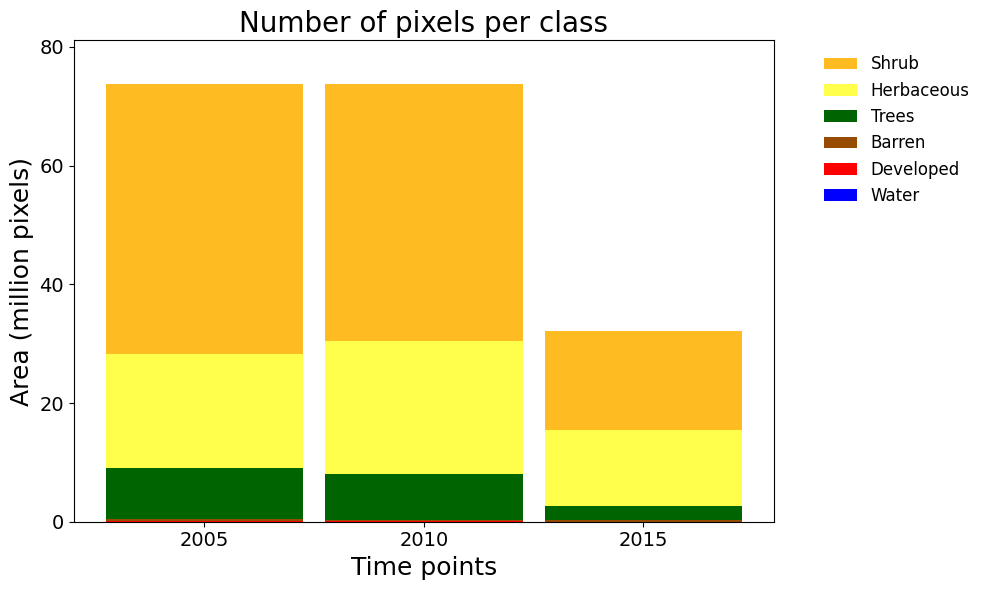

Files saved to: /content/glance_data/output


In [10]:
import os
import glob
import re
import numpy as np
import pandas as pd
import rasterio
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# --- 1. Configuration and Setup ---

# Define input and output directories
input_dir = "/content/glance_data/masked"
output_path = "/content/glance_data/output"
noData_value = 255

# Ensure output directory exists
os.makedirs(output_path, exist_ok=True)

# Define class metadata (ID, Name, Color) based on utils.py
# Colors are formatted with '#' for matplotlib compatibility
class_labels_dict = {
    1: {'name': 'Water',      'color': '#0000FF'},
    2: {'name': 'Ice/Snow',   'color': '#AAAAFF'},
    3: {'name': 'Developed',  'color': '#FF0000'},
    4: {'name': 'Barren',     'color': '#964B00'},
    5: {'name': 'Trees',      'color': '#006400'},
    6: {'name': 'Shrub',      'color': '#FFBB22'},
    7: {'name': 'Herbaceous', 'color': '#FFFF4C'}
}

# --- 2. File Discovery and Sorting ---

# Search for all .tif files in the masked directory
search_pattern = os.path.join(input_dir, "*.tif")
raw_paths = glob.glob(search_pattern)

def get_year_from_filename(filepath):
    """
    Extracts the 4-digit year from the filename using a regular expression.

    Parameters
    ----------
    filepath : str
        The full path or filename of the raster image (e.g., '/path/to/glance_2005.tif').

    Returns
    -------
    int
        The 4-digit year extracted from the filename. Returns 0 if no pattern matches.
    """
    filename = os.path.basename(filepath)
    match = re.search(r"(\d{4})\.tif$", filename)
    if match:
        return int(match.group(1))
    return 0

# Sort paths chronologically based on the year in the filename
image_paths = sorted(raw_paths, key=get_year_from_filename)

# Create a corresponding list of years
years_from_files = [get_year_from_filename(p) for p in image_paths]

print(f"Found {len(image_paths)} images.")
print(f"Years: {years_from_files}")


# --- 3. Processing Function ---

def process_and_plot_pixel_counts(
    image_paths,
    years,
    class_labels_dict,
    output_dir,
    no_data_value=255,
):
    """
    Processes raster images to count pixels per class, plots a stacked bar chart,
    and exports the results to a CSV file.

    Parameters
    ----------
    image_paths : list of str
        List of file paths to the raster images (must be sorted).
    years : list of str or int
        List of years corresponding to the images.
    class_labels_dict : dict
        Dictionary mapping class IDs to metadata (must contain "name" and "color").
    output_dir : str
        Directory path where the output plot and CSV will be saved.
    no_data_value : int, optional
        Pixel value to be treated as NoData.

    Returns
    -------
    pd.DataFrame
        The pivot table containing pixel counts per year and class.
    """
    # 1. Validate that input lengths match
    if len(image_paths) != len(years):
        raise ValueError(
            f"Input mismatch: {len(image_paths)} images vs {len(years)} years.",
        )

    records: list[dict] = []

    # 2. Iterate through each year and corresponding image path
    for year, path in zip(
        years,
        image_paths,
    ):
        # 3. Read the raster data
        with rasterio.open(
            path,
        ) as src:
            data = src.read(
                1,
            )

        # 4. Count unique pixel values
        values, counts = np.unique(
            data,
            return_counts=True,
        )

        # 5. Process counts and map to class names
        for value, count in zip(
            values,
            counts,
        ):
            value = int(value)

            # Filter out NoData values
            if value == no_data_value:
                continue

            # Skip classes not defined in the dictionary
            if value not in class_labels_dict:
                continue

            records.append(
                {
                    "Year": year,
                    "ClassID": value,
                    "ClassName": class_labels_dict[value]["name"],
                    "Pixels": int(count),
                },
            )

    # 6. Create DataFrame and Pivot Table
    df_pixels = pd.DataFrame(
        records,
    )

    pivot_pixels = (
        df_pixels.pivot_table(
            index="Year",
            columns="ClassName",
            values="Pixels",
            aggfunc="sum",
        )
        .fillna(
            0,
        )
        .astype(
            int,
        )
    )

    years_array = pivot_pixels.index.values

    # 7. Determine Y-axis scaling factor and label
    max_val = pivot_pixels.to_numpy().max()

    if max_val >= 1_000_000:
        scale_factor = 1_000_000
        y_label = "Area (million pixels)"
    elif max_val >= 1_000:
        scale_factor = 1_000
        y_label = "Area (thousand pixels)"
    elif max_val >= 100:
        scale_factor = 100
        y_label = "Area (hundred pixels)"
    else:
        scale_factor = 1
        y_label = "Area (pixels)"

    pivot_scaled = pivot_pixels / scale_factor

    print(
        "Pixel counts per time point and class:",
    )
    print(
        pivot_pixels,
    )

    # 8. Prepare color map and sorting logic
    class_ids_plot = sorted(
        class_labels_dict.keys(),
    )

    color_map = {
        class_labels_dict[class_id]["name"]: class_labels_dict[class_id]["color"]
        for class_id in class_ids_plot
    }

    # Calculate Net Change to determine stack order
    first_year = years_array[0]
    last_year = years_array[-1]

    # Handle cases where a class might be missing in first or last year
    try:
        net_change_per_class = (
            pivot_scaled.loc[last_year]
            - pivot_scaled.loc[first_year]
        )
    except KeyError:
        # Fallback if specific years are missing, use first/last available
        net_change_per_class = (
            pivot_scaled.iloc[-1]
            - pivot_scaled.iloc[0]
        )

    # Map names back to IDs for tie-breaking
    name_to_id_map = {
        v["name"]: k
        for k, v in class_labels_dict.items()
    }

    df_sorting = net_change_per_class.to_frame(
        name="net_change",
    )
    df_sorting["class_id"] = df_sorting.index.map(
        name_to_id_map,
    )

    # Sort: Net Change (Desc) then Class ID (Desc)
    classes_for_stack = list(
        df_sorting.sort_values(
            by=[
                "net_change",
                "class_id",
            ],
            ascending=[
                False,
                False,
            ],
        ).index,
    )

    # Legend order: Reversed stack order
    classes_for_legend = list(
        reversed(classes_for_stack),
    )

    # 9. Generate the Stacked Bar Chart
    fig, ax = plt.subplots(
        figsize=(
            10,
            6,
        ),
    )

    x = np.arange(
        len(years_array),
    )
    width = 0.9
    base = np.zeros(
        len(years_array),
        dtype=float,
    )
    patches_by_class: dict[str, plt.Artist] = {}

    for cls in classes_for_stack:
        if cls not in pivot_scaled.columns:
            continue

        values_cls = pivot_scaled[cls].reindex(
            years_array,
            fill_value=0.0,
        ).values

        bars = ax.bar(
            x,
            values_cls,
            bottom=base,
            width=width,
            label=cls,
            color=color_map.get(cls, "gray"),
        )
        patches_by_class[cls] = bars[0]
        base += values_cls

    # 10. Configure Axes
    ax.set_xticks(
        x,
    )
    ax.set_xticklabels(
        years_array,
    )

    # Adaptive rotation for X-axis labels
    n_labels = len(years_array)
    if n_labels <= 7:
        rotation = 0
        ha = "center"
    elif n_labels <= 12:
        rotation = 45
        ha = "right"
    else:
        rotation = 90
        ha = "center"

    plt.setp(
        ax.get_xticklabels(),
        rotation=rotation,
        ha=ha,
    )

    ax.tick_params(
        axis="both",
        labelsize=14,
    )
    ax.set_ylabel(
        y_label,
        fontsize=18,
    )
    ax.set_xlabel(
        "Time points",
        fontsize=18,
    )
    ax.set_title(
        "Number of pixels per class",
        fontsize=20,
    )

    # Y-axis limit and formatting
    y_max_scaled = base.max() * 1.1 if base.max() > 0 else 1.0
    ax.set_ylim(
        0,
        y_max_scaled,
    )
    ax.yaxis.set_major_locator(
        ticker.MaxNLocator(
            nbins=5,
            integer=True,
        ),
    )
    ax.yaxis.set_major_formatter(
        ticker.FormatStrFormatter(
            "%d",
        ),
    )

    # 11. Add Legend
    handles = [
        patches_by_class[cls]
        for cls in classes_for_legend
        if cls in patches_by_class
    ]
    labels = [
        cls
        for cls in classes_for_legend
        if cls in patches_by_class
    ]

    ax.legend(
        handles,
        labels,
        bbox_to_anchor=(
            1.05,
            1.0,
        ),
        loc="upper left",
        frameon=False,
        fontsize=12,
    )

    plt.tight_layout()

    # 12. Save Figure
    out_fig = os.path.join(
        output_dir,
        "graph_pixel_per_class.png",
    )
    plt.savefig(
        out_fig,
        format="png",
        bbox_inches="tight",
        dpi=300,
    )
    plt.show()

    # 13. Save CSV
    csv_output_path = os.path.join(
        output_dir,
        "pixels_per_class_per_year.csv",
    )
    pivot_pixels.to_csv(
        csv_output_path,
        index_label="Year",
    )
    print(
        f"Files saved to: {output_dir}",
    )

    return pivot_pixels

# --- 4. Execution ---

# Run the function if files were found
if len(image_paths) > 0:
    df_result = process_and_plot_pixel_counts(
        image_paths=image_paths,
        years=years_from_files,
        class_labels_dict=class_labels_dict,
        output_dir=output_path,
        no_data_value=noData_value,
    )
else:
    print("No .tif files found in the input directory. Check the path and file extensions.")